In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import os
import re
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import models, layers
from IPython.display import Audio
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

Some of these imports are audio specific imports such as librosa and librosa.display which help read audio data, trim, create spectograsm etc.

"from IPython.display import Audio" allows playing audio signals directly in python enviroments.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Instrument_classifier.csv')

The original Instrument_classifier dataframe from the data, import, and cleaning notebook saved as a CSV.

In [4]:
df.head(5)

,File_path,File_name,Instrument,Start_time,End_time,Index,Instrument_encoded,Instrument_0,Instrument_1,Instrument_2,Instrument_3,Instrument_4
0,/content/drive/MyDrive/Drums/Snare 40 (Roy Aye...,Snare 40 (Roy Ayers - Ebony Blaze (Album Versi...,Snare,0,0.100136,2,0,1.0,0.0,0.0,0.0,0.0
1,/content/drive/MyDrive/Drums/Snare 41 (Roy Aye...,Snare 41 (Roy Ayers - The Old One Two (Move To...,Snare,0,0.154694,2,0,1.0,0.0,0.0,0.0,0.0
2,/content/drive/MyDrive/Drums/Snare 42 (Roy Aye...,Snare 42 (Roy Ayers - No Question (Album Versi...,Snare,0,0.189342,2,0,1.0,0.0,0.0,0.0,0.0
3,/content/drive/MyDrive/Drums/Kick 37 (Roy Ayer...,Kick 37 (Roy Ayers - Can't You See Me),Kick,0,0.417596,0,1,0.0,1.0,0.0,0.0,0.0
4,/content/drive/MyDrive/Drums/Kick 38 (Roy Ayer...,Kick 38 (Roy Ayers - Can't You See Me),Kick,0,0.258730,0,1,0.0,1.0,0.0,0.0,0.0


#EDA

The goal for my EDA is to find the best features to classify the audio to the given instruments. Having an audio background, I know that some distinct features in different instruments and in these audio samples could include frequency,time, pitch and their distinct waveforms. Because of this, I will be exploring these features and seeing which imaging could be the best feature for the target variable which are the instruments.

In [5]:
df.describe()

,Start_time,End_time,Index,Instrument_encoded,Instrument_0,Instrument_1,Instrument_2,Instrument_3,Instrument_4
count,2018.0,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000
mean,0.0,0.963397,1.669475,1.788404,0.215560,0.262636,0.161546,0.238355,0.121903
std,0.0,1.213421,1.383116,1.344234,0.411312,0.440176,0.368125,0.426183,0.327255
min,0.0,0.023537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.237596,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.524331,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,1.184558,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,0.0,12.977188,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Statistical summary of all the numerical values as of now.

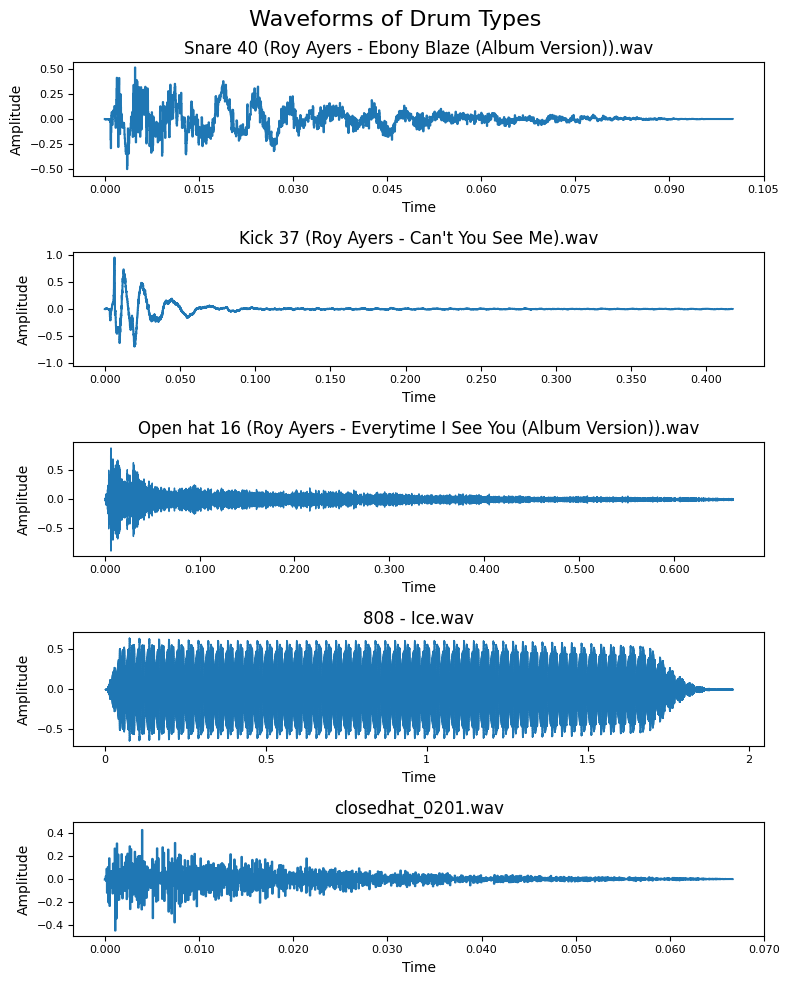

In [11]:
abs_path = Path('/content/drive/MyDrive/Drums/')
instruments = ['Snare', 'Kick', 'Open Hat', '808', 'Closed Hat']

# Create a dictionary to store the first file path for each instrument
first_file_paths = {}

# Iterate through each instrument type
for instrument in instruments:
    first_file_path = df.loc[df['Instrument'] == instrument, 'File_path'].iloc[0]
    first_file_paths[instrument] = first_file_path

fig, axs = plt.subplots(nrows=len(instruments), ncols=1, figsize=(8, 10), sharex=False)
fig.suptitle('Waveforms of Drum Types', fontsize=16)

for i, instrument in enumerate(instruments):
    audio_file = abs_path / first_file_paths[instrument]
    y, sr = librosa.load(str(audio_file))
    y, _ = librosa.effects.trim(y, top_db=50)
    y = librosa.resample(y=y, orig_sr=sr, target_sr=22050)

    axs[i].set_title(f"{audio_file.name}", fontsize=12)
    axs[i].set_ylabel('Amplitude', fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].tick_params(axis='both', which='major', labelsize=8)

    # Plot the waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[i])

plt.tight_layout()
plt.show()

The graph shows the distinct waveform amplitude of each instrument. Each instrument has a very distinct waveform which shows how amplitude over time could be a good consderation for a feature in the predictive / classification model.

In this function, I wanted to find the first instrument of each category from my filepaths to demonstrate each instruments amplitude over time. I did this by iterating over the instrument types, trimming and resampling audio and setting my X and Y to the amplitude and time.

As for resampling, I decided to choose the rate 22050 Hz to ensure compatibility and flexibility for each audio sample. This also lowers computational power compared to standard 44100 Hz.

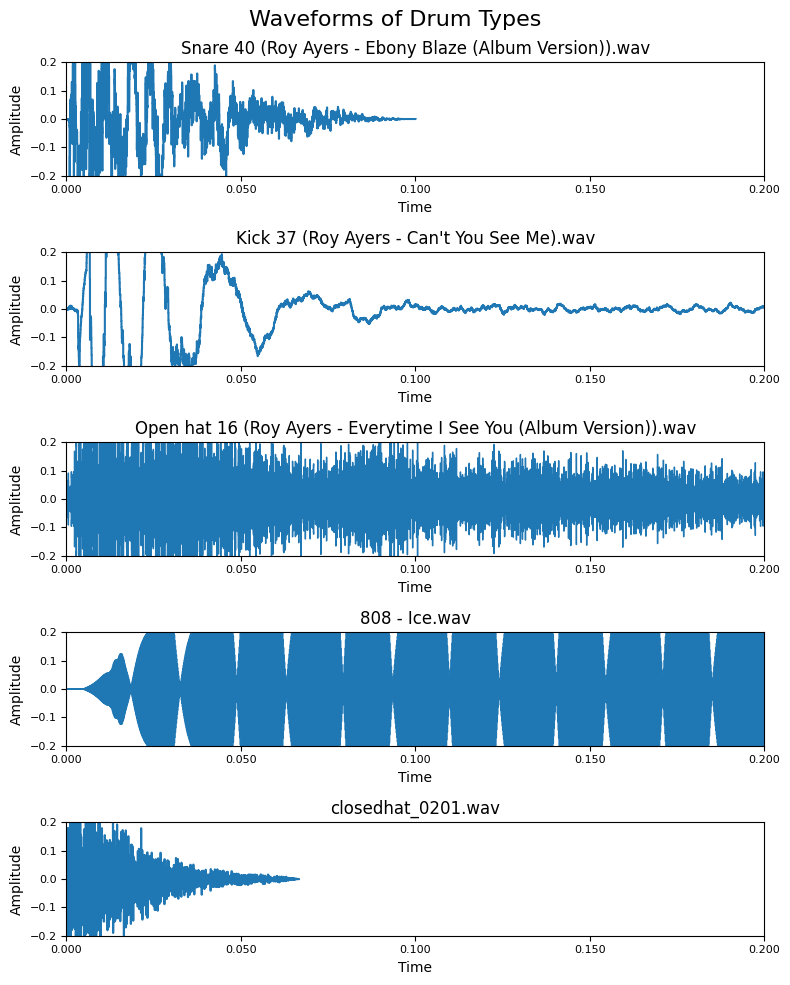

In [12]:
abs_path = Path('/content/drive/MyDrive/Drums/')
instruments = ['Snare', 'Kick', 'Open Hat', '808', 'Closed Hat']

# Create a dictionary to store the first file path for each instrument
first_file_paths = {}

# Iterate through each instrument type
for instrument in instruments:
    first_file_path = df.loc[df['Instrument'] == instrument, 'File_path'].iloc[0]
    first_file_paths[instrument] = first_file_path

fig, axs = plt.subplots(nrows=len(instruments), ncols=1, figsize=(8, 10), sharex=False)
fig.suptitle('Waveforms of Drum Types', fontsize=16)

for i, instrument in enumerate(instruments):
    audio_file = abs_path / first_file_paths[instrument]
    y, sr = librosa.load(str(audio_file))
    y, _ = librosa.effects.trim(y, top_db=50)
    y = librosa.resample(y=y, orig_sr=sr, target_sr=22050)

    axs[i].set_title(f"{audio_file.name}", fontsize=12)
    axs[i].set_ylabel('Amplitude', fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].tick_params(axis='both', which='major', labelsize=8)


    librosa.display.waveshow(y, sr=sr, ax=axs[i])


    axs[i].set_xlim(0, 0.2)


    axs[i].set_ylim(-0.2, 0.2)

plt.tight_layout()
plt.show()

This is similar to the graph above however to show the distinction in the waveforms, I changed the formatting. In this formatting, you can see the pattern of amplitude better.

In [10]:
df = df.set_index('Index')

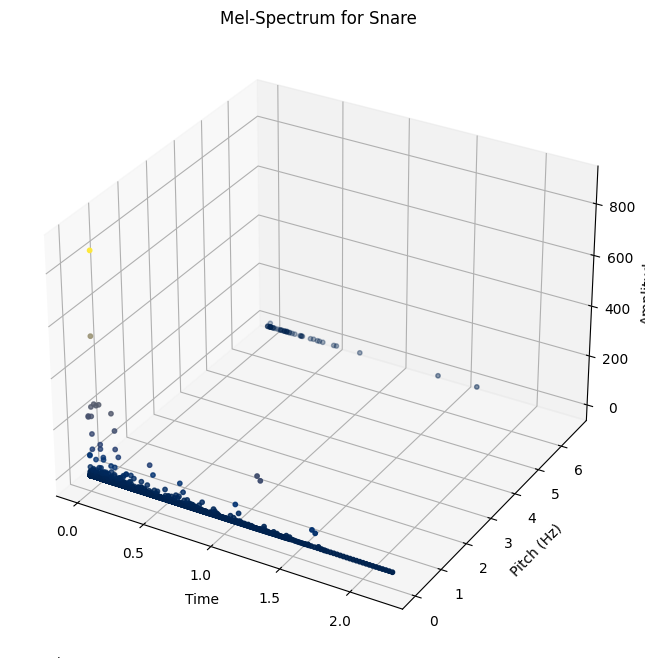

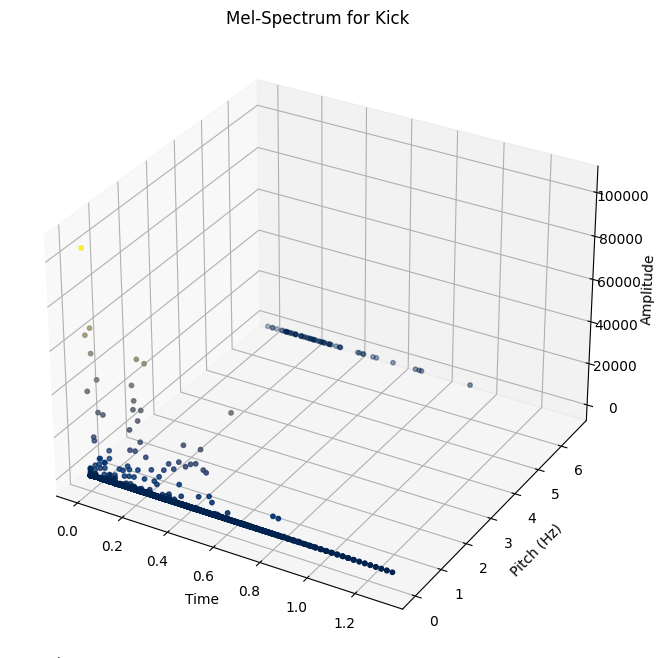

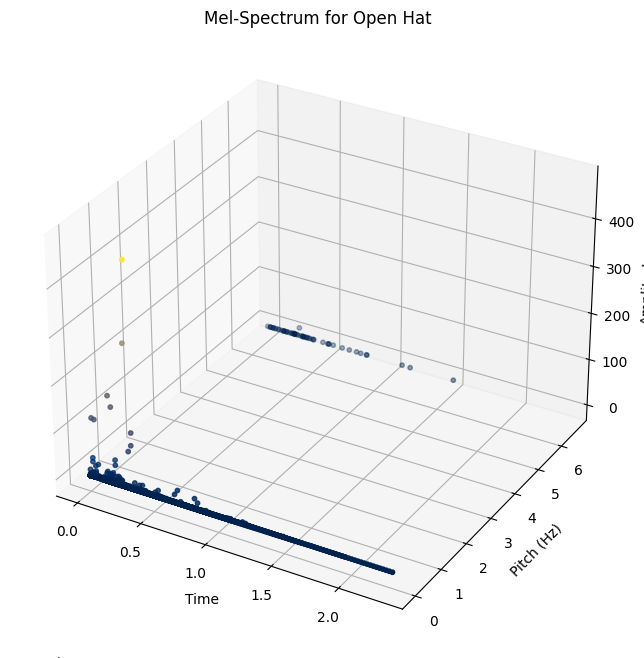

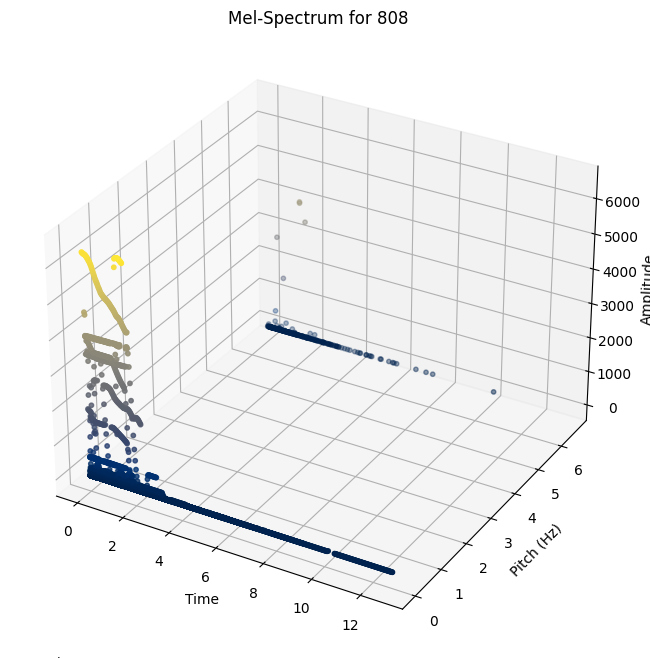

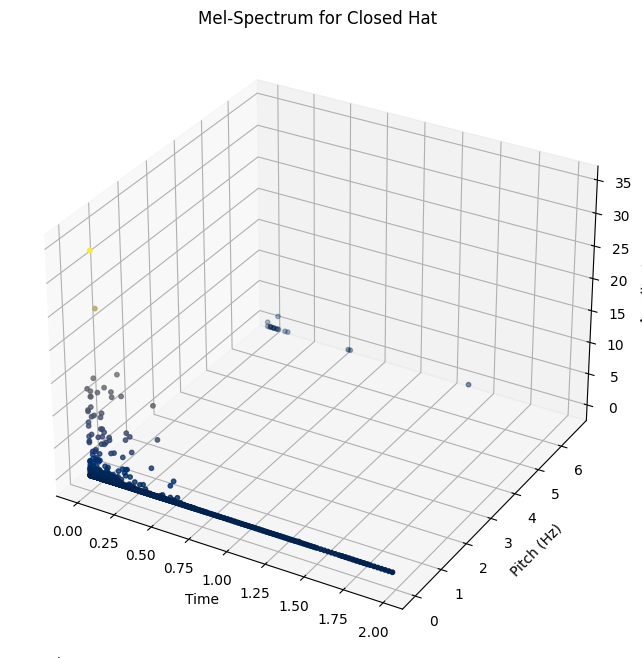

In [11]:
abs_path = Path('/content/drive/MyDrive/Drums/')
instruments = df['Instrument'].unique()

for instrument in instruments:
    # Find all file paths for the current instrument
    instrument_file_paths = df.loc[df['Instrument'] == instrument, 'File_path'].tolist()

    # Create lists to store the pitch and time values for the current instrument
    all_pitch = []
    all_time = []
    all_melspectrogram = []

    for file_path in instrument_file_paths:
        audio_file = abs_path / file_path
        y, sr = librosa.load(str(audio_file))
        y, _ = librosa.effects.trim(y, top_db=50)
        y = librosa.resample(y=y, orig_sr=sr, target_sr=22050)


        melspectrogram = librosa.feature.melspectrogram(y=y)


        pitch = librosa.core.mel_to_hz(np.linspace(0, sr / 2, melspectrogram.shape[0]))
        time = np.linspace(0, len(y) / sr, num=melspectrogram.shape[1], endpoint=False)


        all_pitch.extend(pitch)
        all_time.extend(time)
        all_melspectrogram.extend(melspectrogram.flatten())


    min_length = min(len(all_pitch), len(all_time), len(all_melspectrogram))
    all_pitch = np.array(all_pitch[:min_length])
    all_time = np.array(all_time[:min_length])
    all_melspectrogram = np.array(all_melspectrogram[:min_length])

    # Create the 3D scatter plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(all_time, all_pitch, all_melspectrogram, s=10, c=all_melspectrogram, cmap='cividis')

    plt.title(f"Mel-Spectrum for {instrument}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Pitch (Hz)')
    ax.set_zlabel('Amplitude')

    plt.show()

This 3D scatter plot shows each type of instrument and its relationship between pitch and amplitude over time.

For context, pitch is the perception of how high or low a sound is which allows us to distinguish between different musical notes and tones (Vocabulary.com, 2024), amplitude is a measure of the magnitude of a sound wave, representing the maximum displacement of the wave from its resting position or equilibrium(Teachmeaudio.com, 2024) and time is the length of the sample.

There are many noticable features of what makes each instrument unique accuratly. Some of these include...
 - The 808 had a larger amplitude over time which is very accurate to the instrument. As show in the waveforms while they all remain in a simialr frequency and pitch, they often vary in the amplitude.

 - As for the open hat and closed hat, they show a correlation of similar pitch
and amplitude over time and this is very accurate to the instrument because they are both very similar. The open hat is slightly less numerically than the closed hat which makes sense in the real world.  I also find it intresting that the closed hat has the least amount of outliers visually.

- The amplitude was highest for the kick and 808. This makes alot of sense as there is high magnitude for the amplitude.

- There are outliers in the each instrument. Overall, audio pitches can vary even based on instrument but they all typically have ranges of frequencies that are common amoung one another. I think it is important to keep the outliers in this as they represent how samples can vary, for example, specific pitches for samples such as a snare can depend on the genre, key of the song, and the desired sound as there can be diffrent kind of snares. This is something important to consider in the feature decision making process and for modeling. This could also be useful information to improve the model.


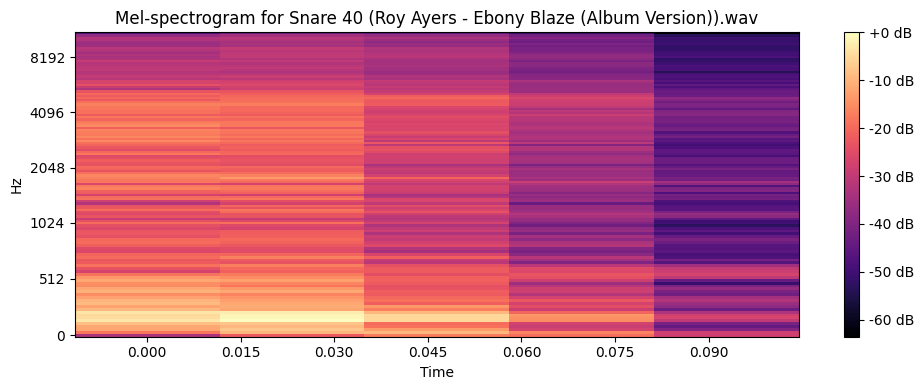

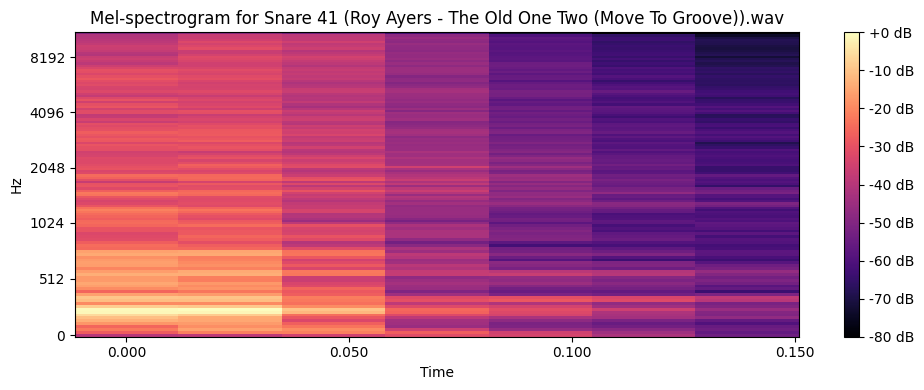

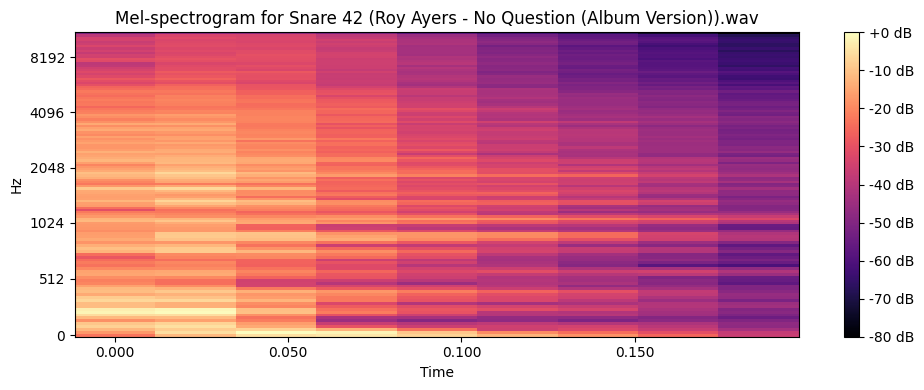

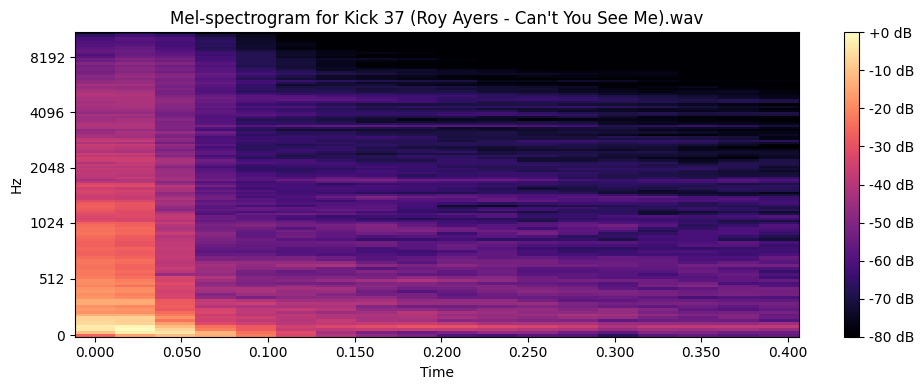

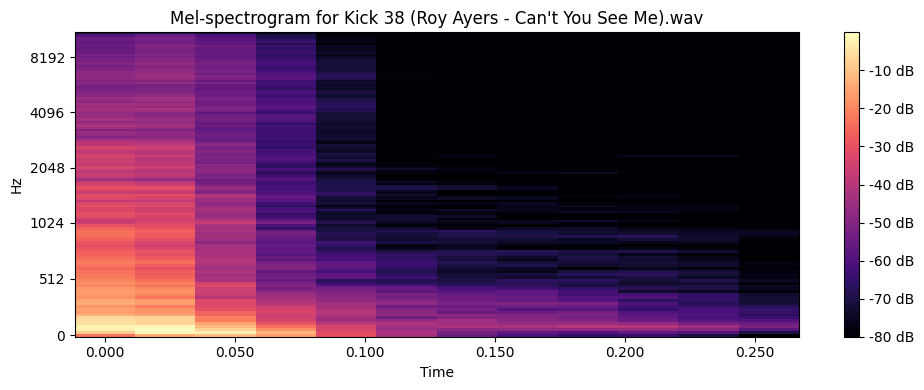

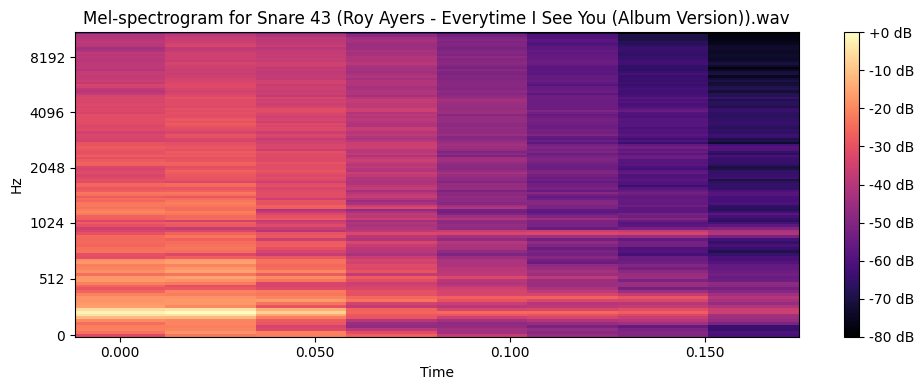

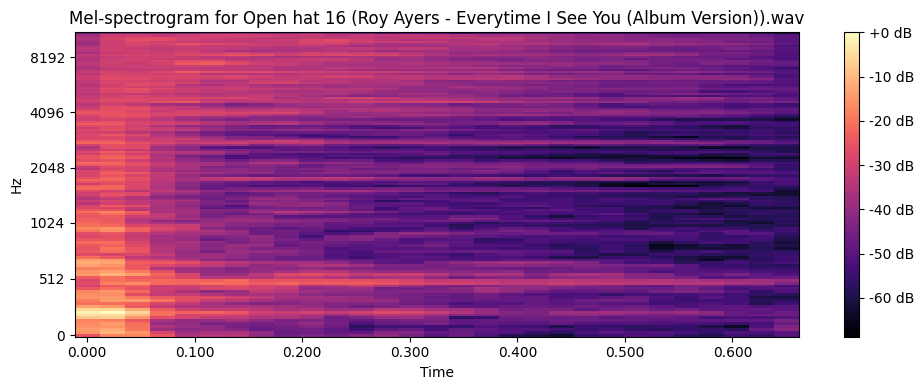

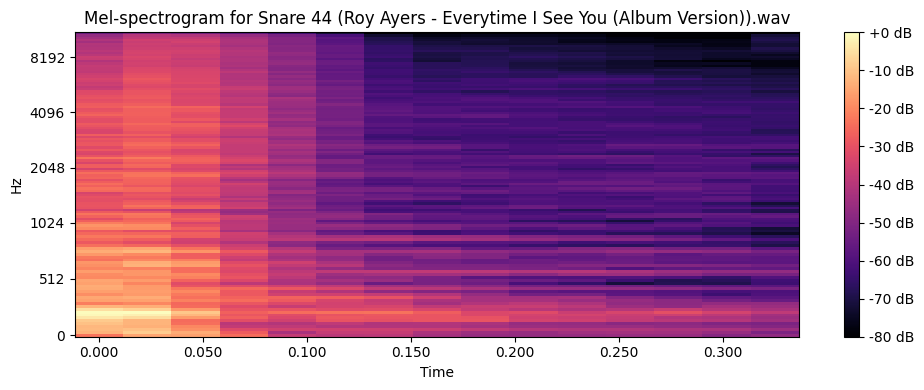

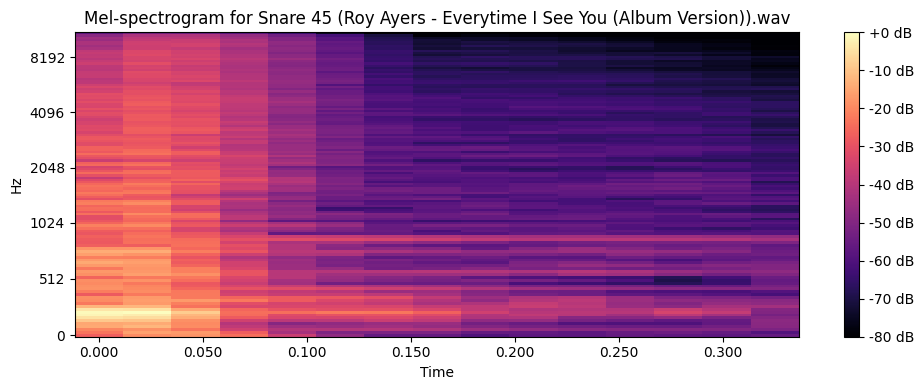

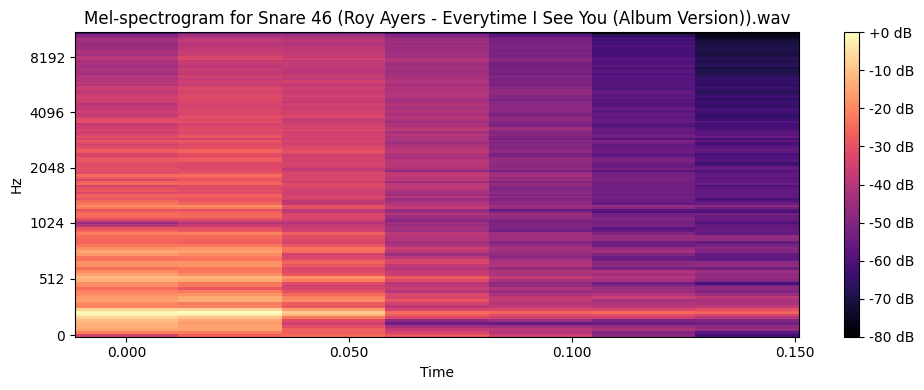

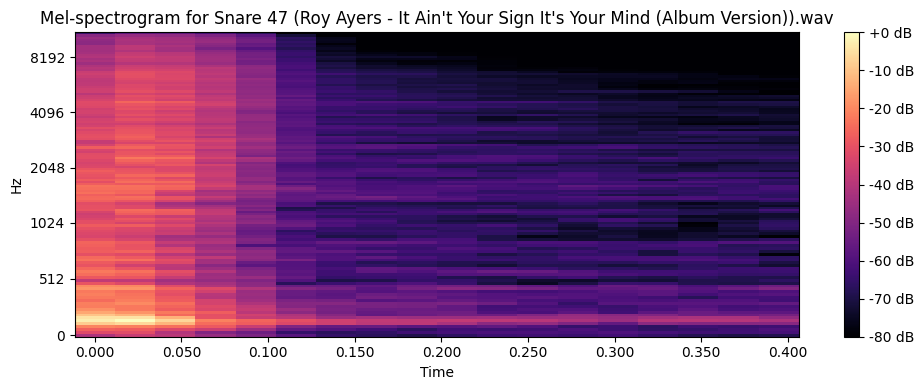

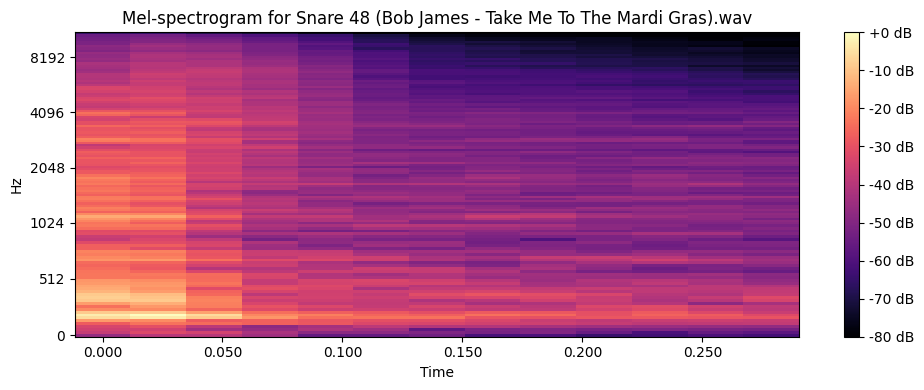

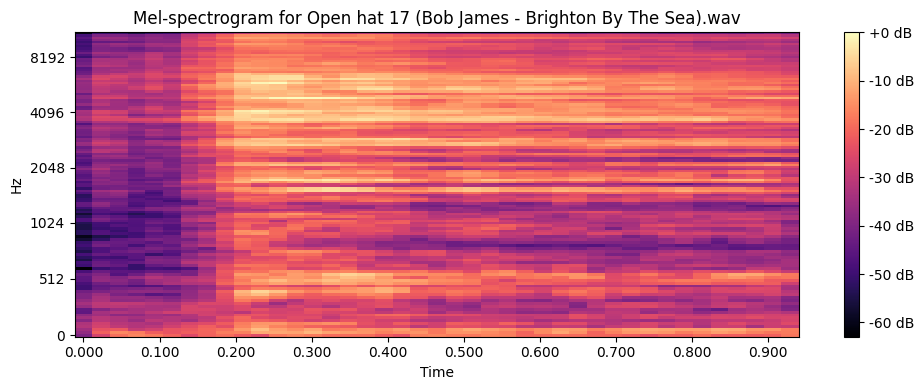

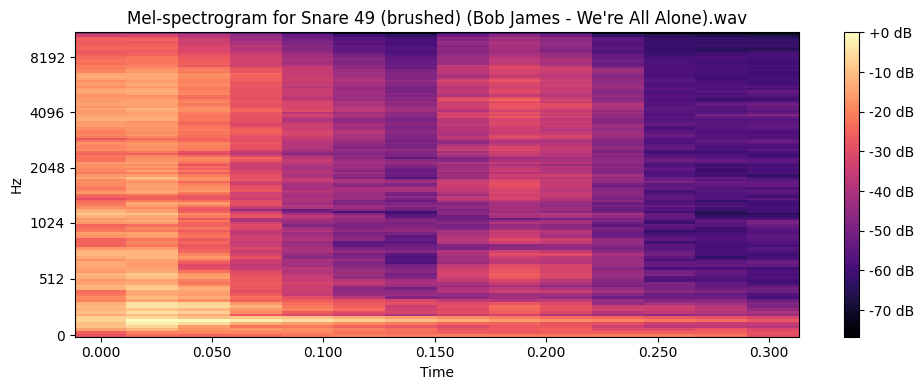

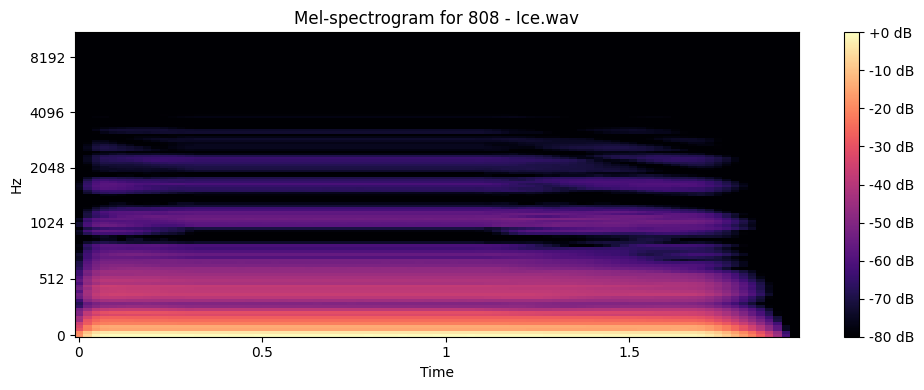

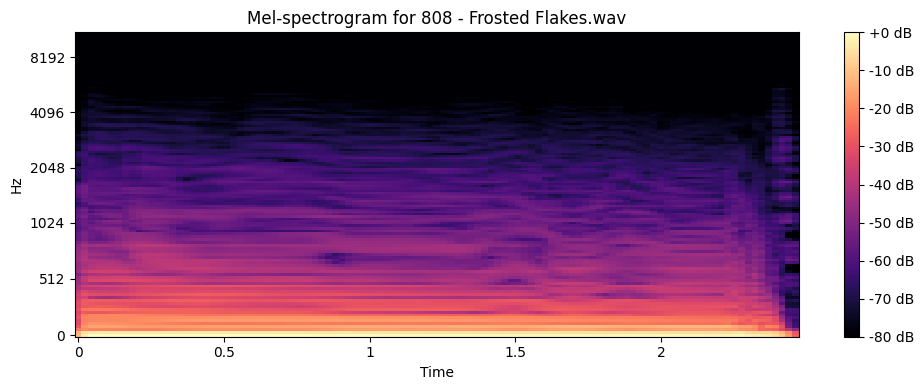

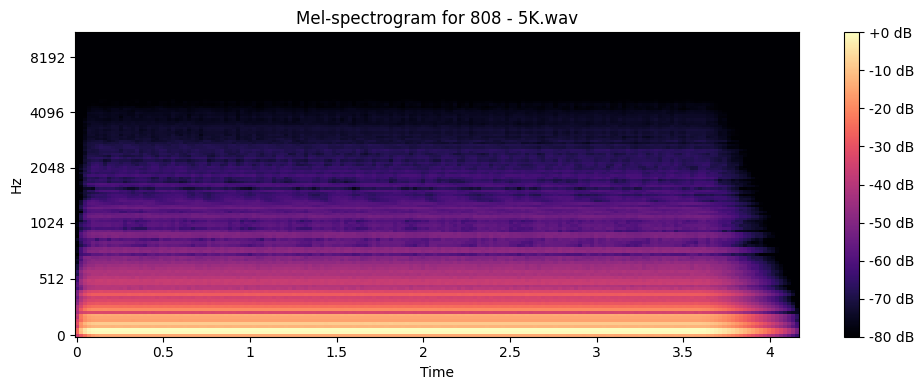

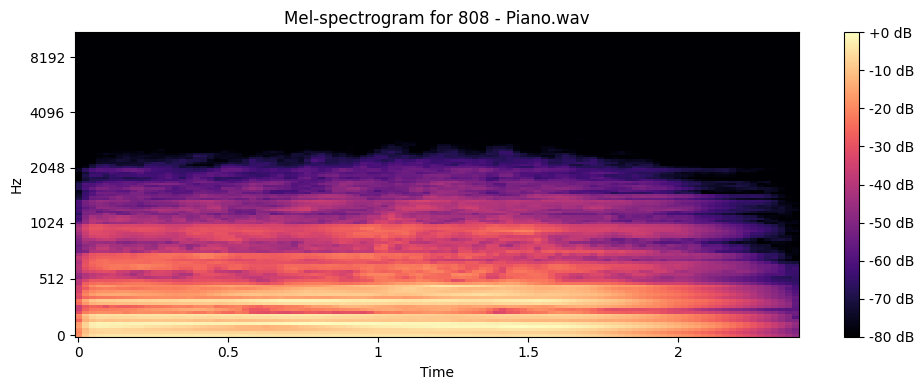

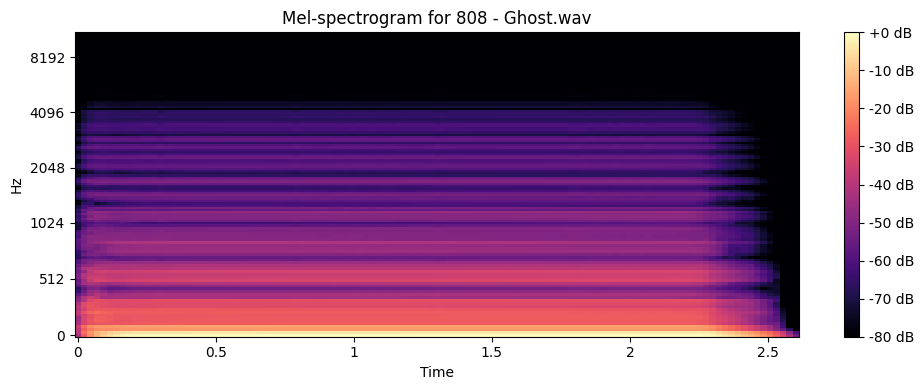

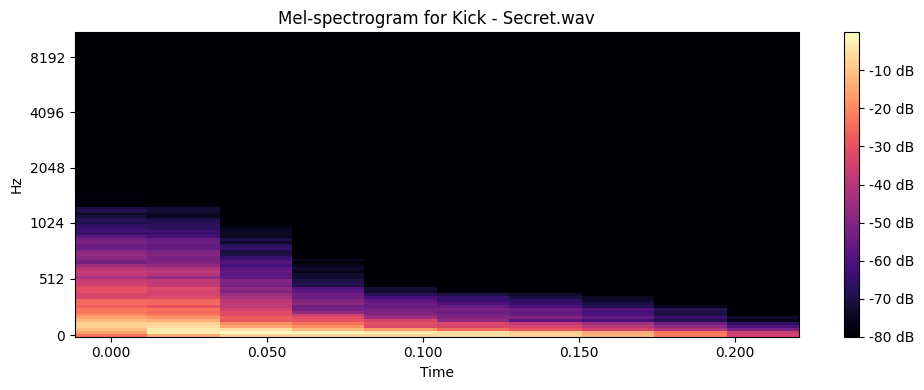

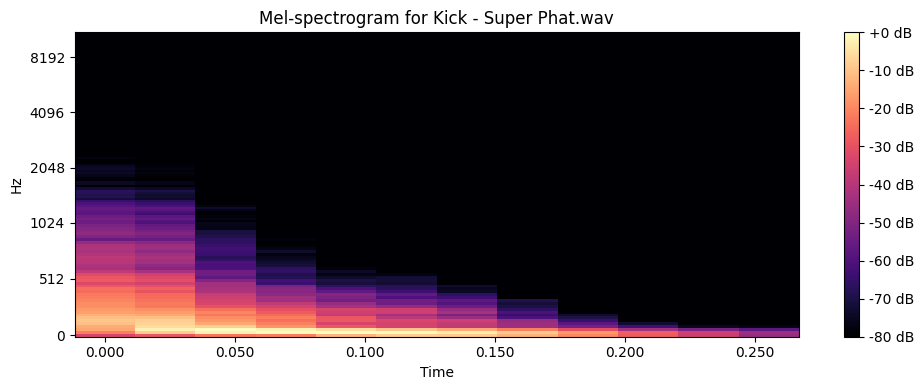

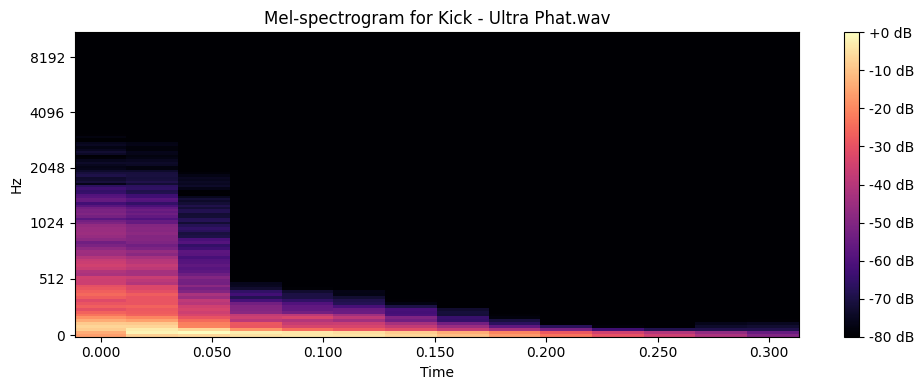

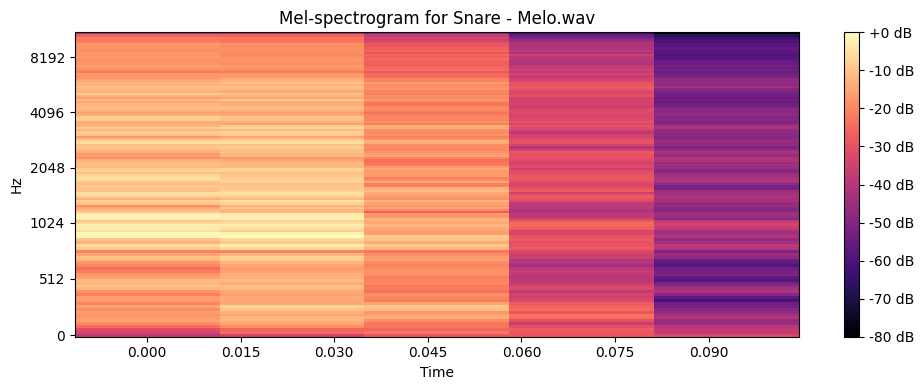

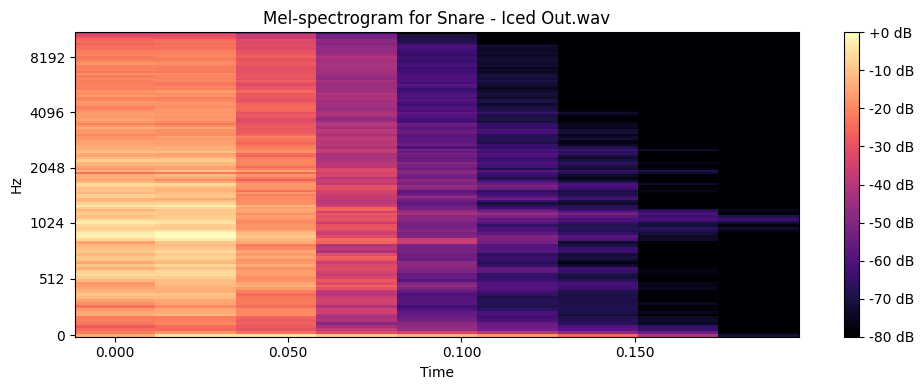

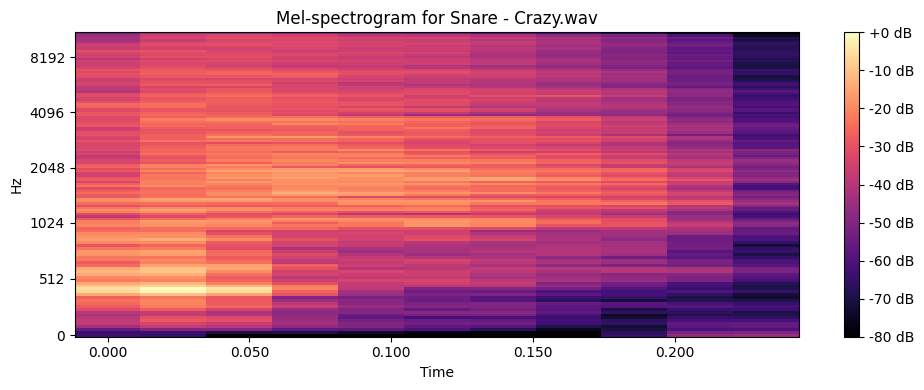

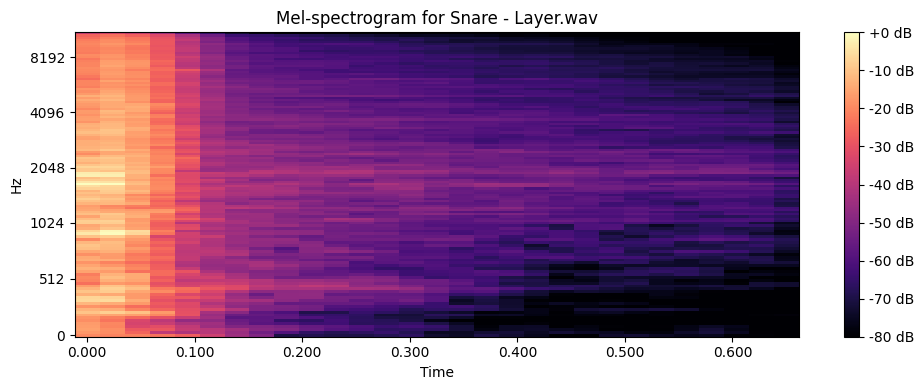

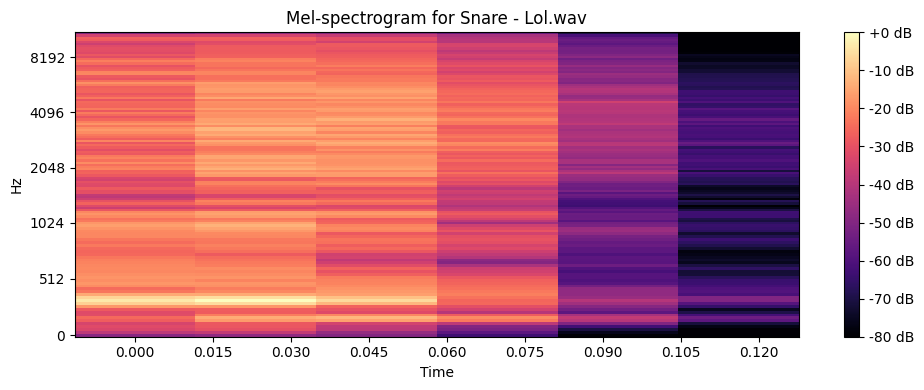

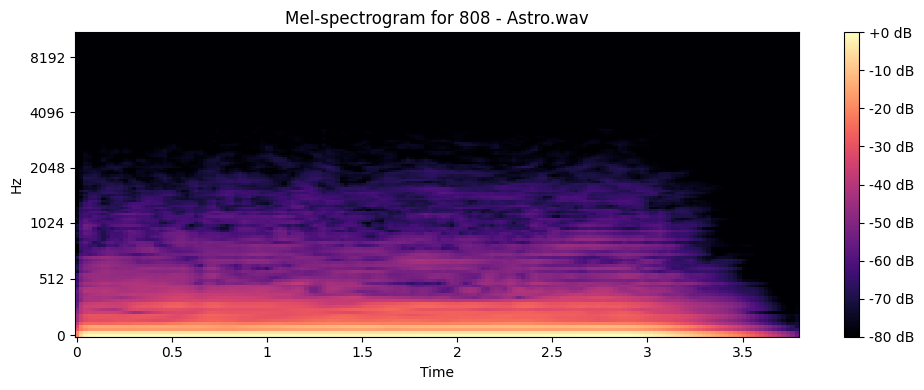

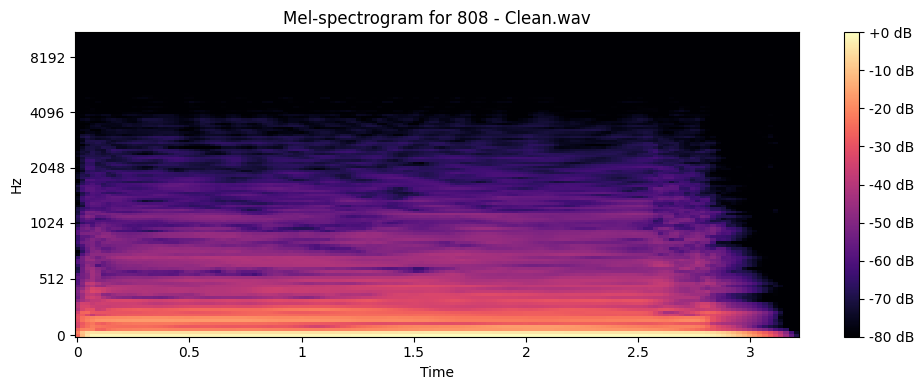

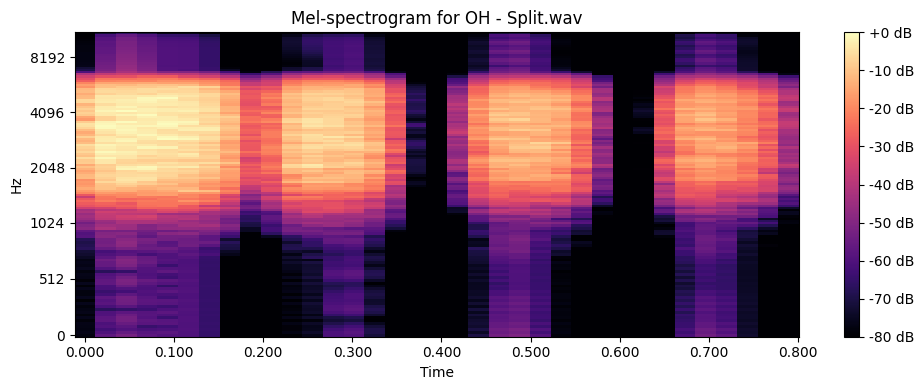

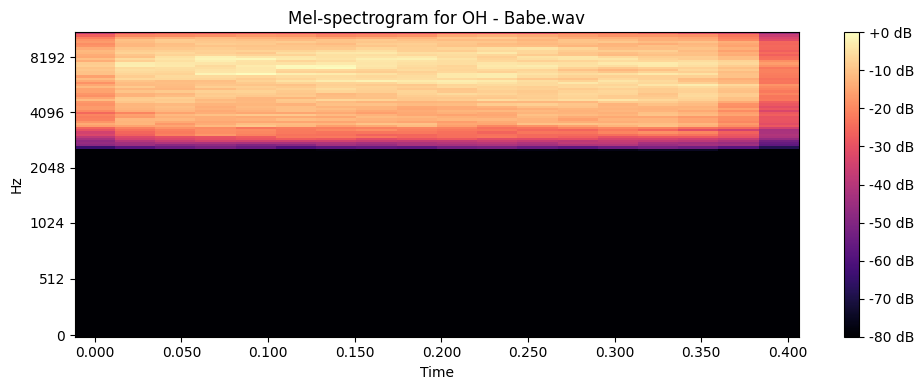

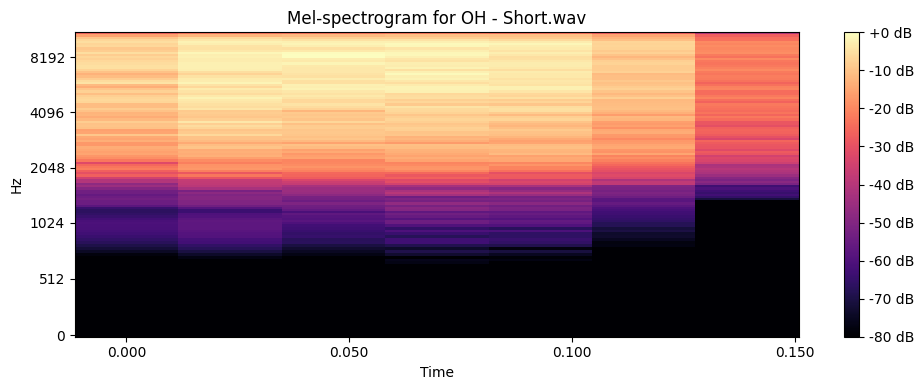

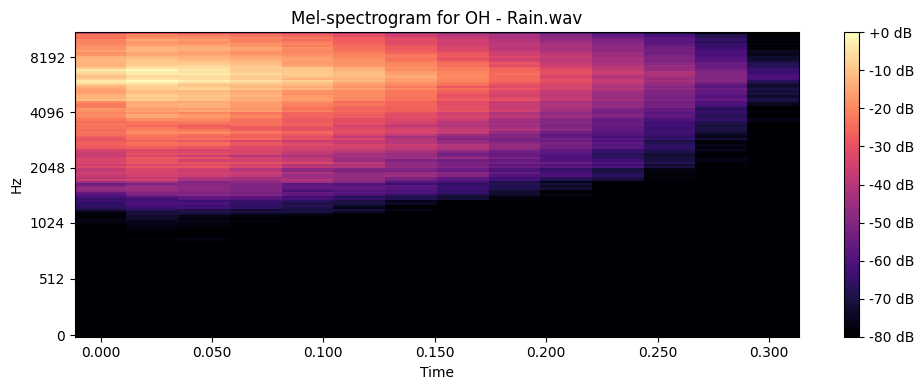

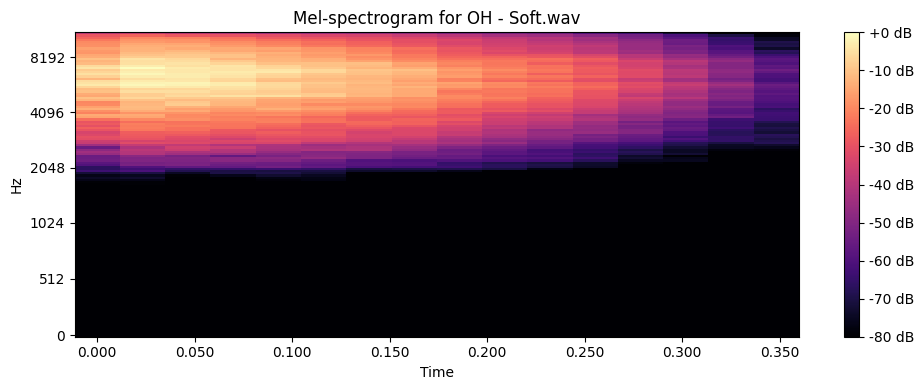

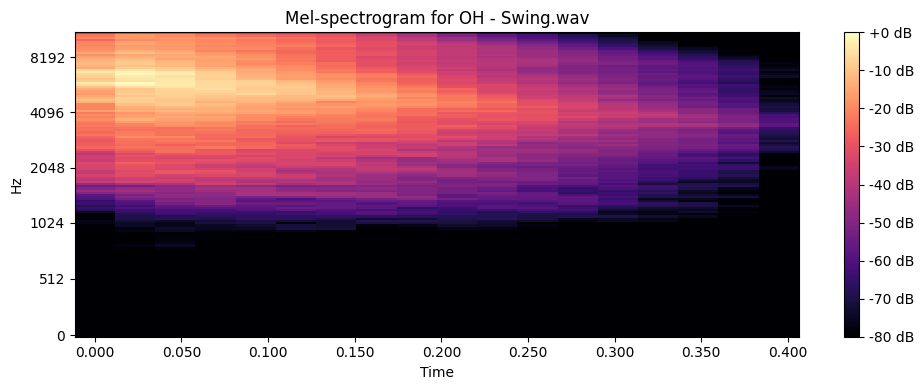

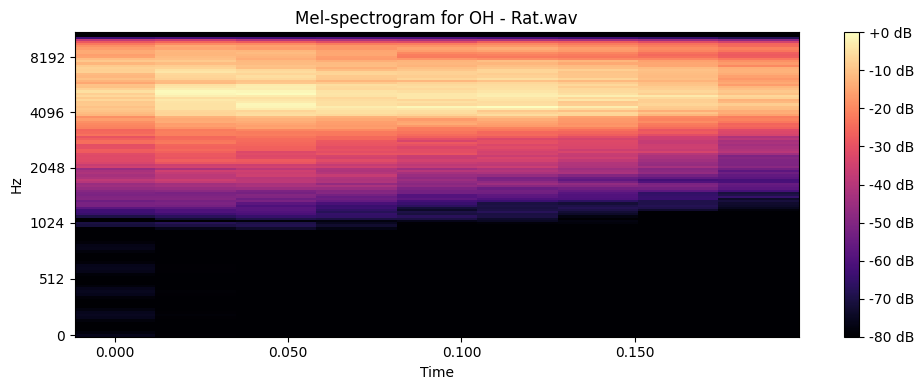

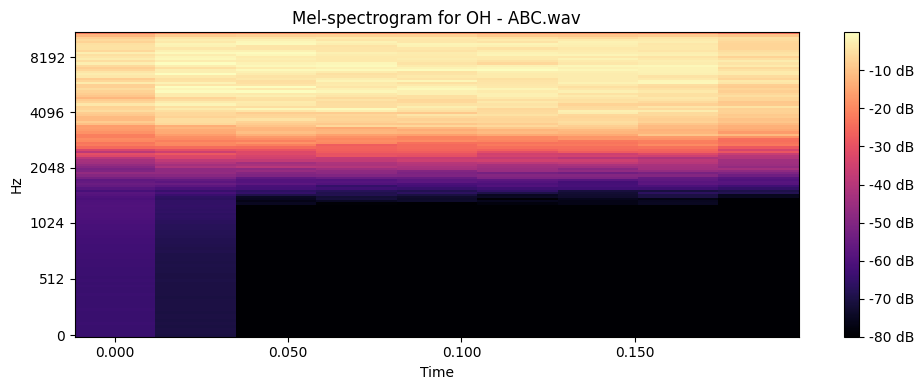

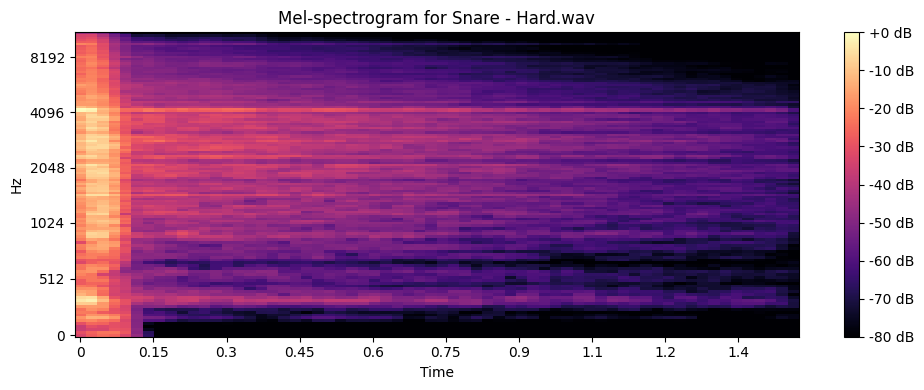

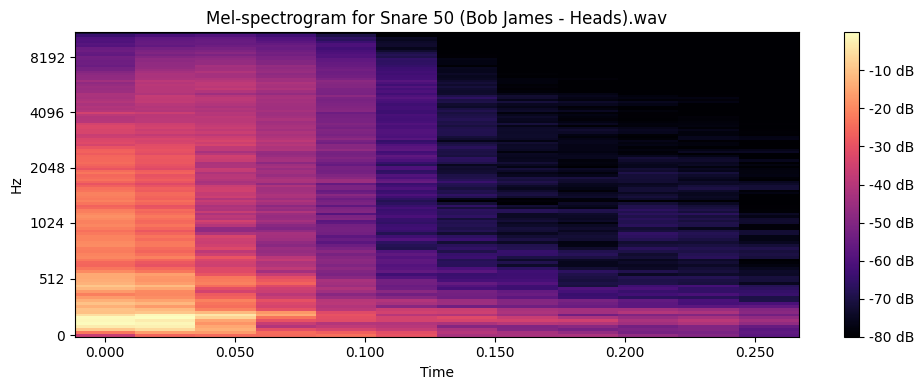

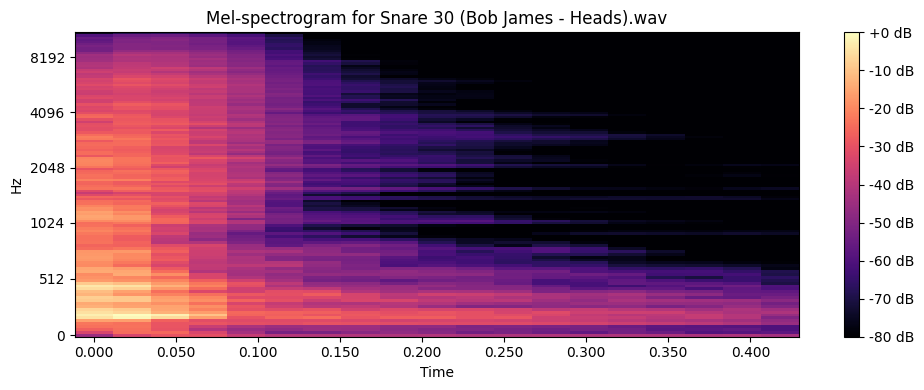

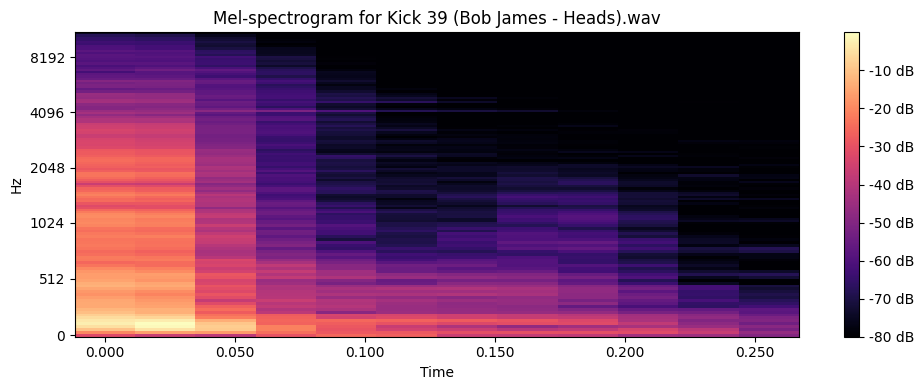

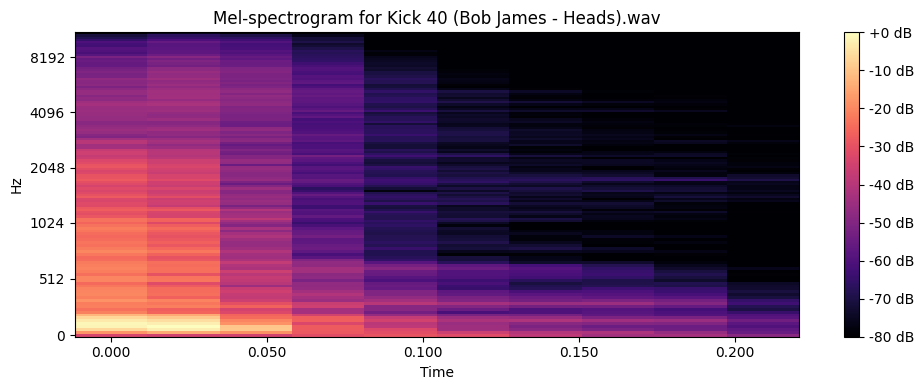

KeyboardInterrupt: 

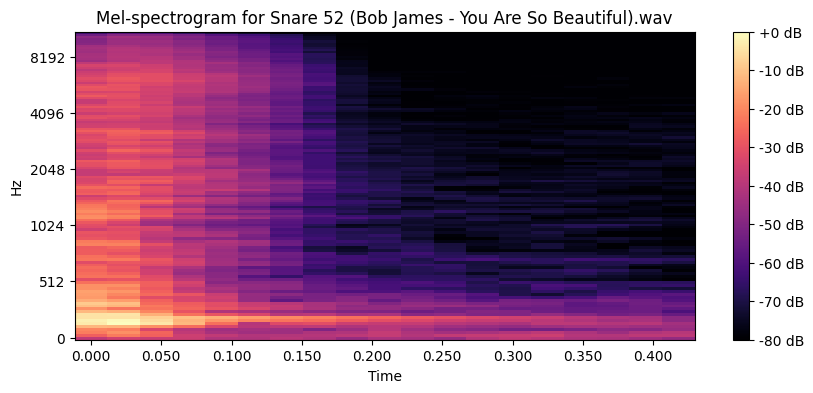

In [ ]:
LENGTH=100
samples = abs_path

# Creating lists to fill
samples_data = []
samples_dtype = []
samples_vizdata = []

for sample in os.listdir(samples):
    sample_array = np.zeros((128, LENGTH, 3))
    visual_array = np.zeros((128, LENGTH))

    audio, sr = librosa.load(os.path.join(samples, sample), sr=22050)
    audio, _ = librosa.effects.trim(audio, top_db=50)
    audio = librosa.resample(y=audio, orig_sr=sr, target_sr=22050)

    melspect = librosa.feature.melspectrogram(y=audio)

    visual_array = librosa.power_to_db(melspect, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(visual_array, x_axis='time', y_axis='mel', sr=22050)
    plt.title(f'Mel-spectrogram for {sample}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    samples_data.append(sample_array)
    samples_dtype.append(sample)
    samples_vizdata.append(visual_array)

Note: Stopped the code since I did not want all the examples of mel-spectogram of my instruments but wanted to see the output at a random selection of instruments.

These mel-spectograms show examples of how the frequency and dB(Decibels)of my Instrument selection looks like.

Some key findings and things that instrested me were
- the 808s showed a wave-like pattern similar to how the waveforms looks liked, this shows a large amplitude in frequency as well.
- The kicks all had a shelf as they which is accurate because they start strong and db decreases over time
- The open hat and closed hats sit at a similar frequency with a high dB.
- The snares cover the entire spectrum of frequency and dB showing how diffrent they appear.


In summary: During this process, The goal for my EDA was to find the best features for a model to predict what audio belongs to which instrument type. Having an audio background, I know that some distinct features in different instruments and in these audio samples could include time, pitch, frequency, amplitude etc. Digging further into this, I applied more research into my predictions with the selected features and the audio data including, understanding the relationship between pitch and amplitude over time, deciding sample rates (44.100kHz vs 22050kHz) for the audio file for the purposes of this project, and considering input sizes that would fit the audio and the model best. These were apart of my biggest roadblocks for a while as well, especially, deciding what model and features would work best as there were many pros and cons to using pitch, amplitude, time v.s. the dataset that I already created that gave unique numerical index values. Deciding between that and the Convolutional Neural network and the Random forest was also apart of the process. Another roadblock was that I was not able to obtain the correct sample input size for my model leading to errors along the way and getting my graphs to run accurately. My initial

Intially, I wasnt sure how to approach the EDA with audio data so I made many errors throughout my process such as using mock audio libraries ending up with while very intresting graphs, however, were inacurate. In the end, of this process I was able to decide my best parameters for my audio which includes 22050 Hz, thus, being able to demonstrate the potential features and deciding on using CNN because I discovered that there was more potential for its use further down the road to implement diffrent types of imaging vs the other models.            

Some risks and limitations were related to my roadblocks which included how to quantify pitch, amplitude, time if I were to feature engineer and use them in my models main features. Another was deciding between classification vs Convolutional Neural network which took me a while to figure out, limiting the time to further explore more potentially better features. Something to consider with the CNN model would be how much RAM it takes to run 2018 audio files, converting my audio files into arrays with Pitch, Time, and Amplification, and providing the right amount of input samples. I ran into many errors in this process with computation and I relaize that may be an issue that I run into when modeling.

Based on my EDA, I think I will try to focus on using the CNN model for multiclass classifcation because I think overall, the results obtained in the EDA showed alot of insight to pitch, time, frequency and more in both the spectogram and the 3D model. Because of this, I this that this model would be the best model to use.

Three concrete action steps that I will take next is to try to use the CNN model, however, implement random forest as an additional model as models that I know may work with this type of multiclass classification problem. I will also save all the research done here as apart of my sources and lastly, make note of the audio parameters I chose to ensure consistency throughout the code.

#Models: CNN & MLP and additional models. (Approach to CNN with imaging to audio data model and Random Forest)
1) MLP


In [6]:
one_hot_columns = ['Instrument_0', 'Instrument_1', 'Instrument_2', 'Instrument_3', 'Instrument_4']
X = df[one_hot_columns]

y = df['Instrument_encoded']

Using my one hot encoded columns from my dataframe with the MLP and having my target variable be my encoded instrument column.

In [7]:
# Calculate the number of unique instruments
num_classes = df['Instrument'].nunique()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

MLP Implementation:
- Using Sequential API in Keras as this is the import required for MLP.
- Creating Three hidden layers with 128, 64, and 32 units.
- Using ReLU (Rectified Linear Unit) activation function to work for efficiency in managing audio data.
- Using Softmax activation function to convert the output into probabilities since this is a multi-class classification problem.
- Using optimizer Adam and categorical_crossentropy to compile and for a multiclass classification problem.


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
45/45 [==============================] - 2s 14ms/step - loss: 1.0851 - accuracy: 0.8789 - val_loss: 0.4236 - val_accuracy: 1.0000
Epoch 2/10
45/45 [==============================] - 0s 6ms/step - loss: 0.1293 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 0s 6ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 0s 6ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 0s 6ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 8/10
45/45 [=

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 1.0


Note: For my model selection, I ended up working with MLP as an additional model and another type of neural network model. MLP is a artifical neural network that has foundational architecture in deep learning and is used for various machine learning tasks, including classification(Perplexity AI, 2024).

Accuracy score: 1.0
Training Loss: 5.3143e-04
Validation Loss: 4.7816e-04

MLP Evalution : From my findings, the model is overfit due to the accuracy score. While the loss is decreasing and the accuracy is increasing gradually and the model seems to able to accurately predict the validation set, this happens at a very fast rate which could be considered an issue. Something else I noticed is that the training and validation losses are similar numerically for example, 0.0025 and 0.0020 which could mean that it is working well and interpreting the data. There are many things that could be affecting this model however, I think that with more data and also different parameters this could potentially improve.

-------

2) CNN Model

In [10]:
# Start for CNN
one_hot_columns = ['Instrument_0', 'Instrument_1', 'Instrument_2', 'Instrument_3', 'Instrument_4']
X = df[one_hot_columns]
y = df['Instrument_encoded']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

Setting up the CNN similar to the MLP as both are neural nets.

In [16]:
input_shape = X_train.shape[1:]  # Get the input shape from the training data

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

model.add(layers.Flatten())


CNN Implementation:
- Three hidden layers with 128, 64, and 32 units.
- ReLU (Rectified Linear Unit) activation function to work for efficiency in managing audio data.
- Softmax activation function to convert output into probabilities since this is a multi-class classification problem.
- Using optimizer Adam and categorical_crossentropy to compile and for a multiclass classification problem.


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
51/51 [==============================] - 1s 7ms/step - loss: 1.3112 - accuracy: 0.6797 - val_loss: 0.9161 - val_accuracy: 1.0000
Epoch 2/10
51/51 [==============================] - 0s 4ms/step - loss: 0.5846 - accuracy: 0.9845 - val_loss: 0.2228 - val_accuracy: 1.0000
Epoch 3/10
51/51 [==============================] - 0s 4ms/step - loss: 0.1615 - accuracy: 0.9988 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 4/10
51/51 [==============================] - 0s 4ms/step - loss: 0.0559 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 5/10
51/51 [==============================] - 0s 4ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 0s 4ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 0s 4ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 8/10
51/51 [==

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test set loss: {test_loss:.2f}")
print(f"Test set accuracy: {test_accuracy:.2f}")

7/7 [==============================] - 0s 3ms/step - loss: 6.3551e-04 - accuracy: 1.0000
Test set loss: 0.00
Test set accuracy: 1.00


IMPORTANT NOTE:
For my model selection, I ended up adding MLP in addition to the other models that I made which included Random forest, CNN. This particular problem is a multiclass classification problem because it has many classes that require classification.

Overall, the main model I wanted to choose was CNN because I was curious to see how the image data could translate to audio data. While I have worked with CNN before, I was not familiar with the process of how that could look like for audio until now. From my research, I found that as long as you have a way to preserve the temporal and spectral characteristics of audio data, such as the spectrograms or the 3D imaging, it is possible to use CNN in this particular way. You can also use audio data for a CNN across all 3 image channels(RGB) (Nandi, 2021).

Through this experience however, I learned that while this is possible, the feasibility of this is a bit difficult due to computational power of the conversions which require more RAM and in general can be time extensive. I had this issue which led me to formatting my CNN model incorrectly and applying the one hot encoding to the CNN model which is not the appropriate way of classification. Learning from this, I did more research and applied a more appropriate model, MLP which mentioned previously is a neural network that has foundational architecture in deep learning and is used for various machine learning tasks, including classification.

CNN:
Accuracy score:1.0
Loss:0.006

Evaluation : From my findings, the model has a test set loss of approx 0.0061 and a test set accuracy of 1.0 with default epoch value of 10 and .Some key finding from this is that the loss is decreasing and the accuracy is increasing gradually and the model is able to accurately predict the validation set however, the model overfits a bit due to the low validation loss at 0.0066 at epoch 5. The main issue with this model's implementation is the use of the one hot encoding column being processed on a model that does not take in numerical data and only takes in imaging data, this was an error on my end which is why I decided to use MLP as the additional model.

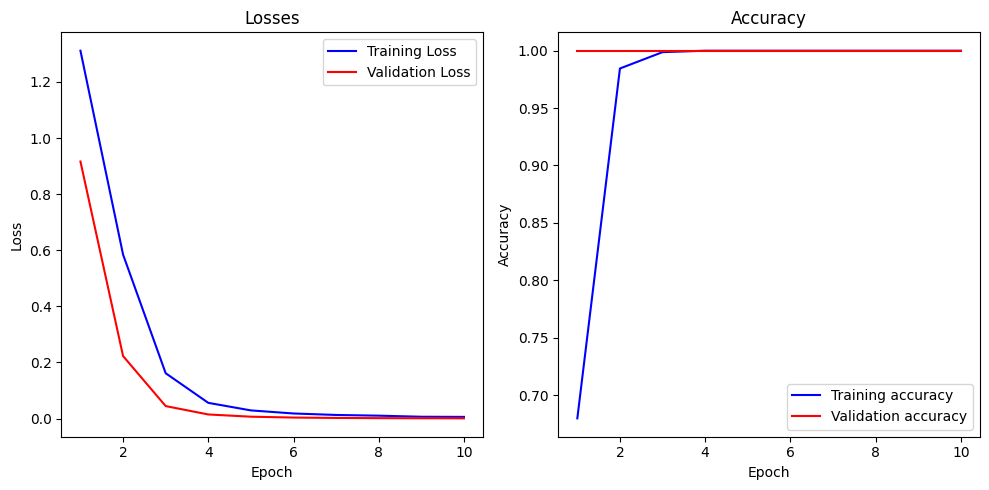

In [19]:
# Losses and Accuracy of model.
history_dict = history.history
loss_values = history_dict['loss']
accuracy_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_accuracy_values = history_dict['val_accuracy']

min_length = min(len(loss_values), len(val_loss_values))
loss_values = loss_values[:min_length]
val_loss_values = val_loss_values[:min_length]

epochs = range(1, min_length + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs, loss_values, 'blue', label='Training Loss')
ax1.plot(epochs, val_loss_values, 'red', label='Validation Loss')
ax1.set_title('Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, accuracy_values[:min_length], 'blue', label='Training accuracy')
ax2.plot(epochs, val_accuracy_values[:min_length], 'red', label='Validation accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Saves model to be used by the prediction Jupyter
model.save('/content/drive/MyDrive/model')

To further evaluate, the validation accuracy seems to overfit and it cna be visually represented in the Accuracy graph above. This makes sense because of the use of the CNN with the numerical columns. This also agains shows the loss is decreasing and the accuracy is increasing gradually and the model is able to accurately predict the validation set however, the model overfits a bit due to the low validation loss at 0.0066 at epoch 5.

Additional models: This is how I would have approached CNN with imaging to audio data model.

In [ ]:
# from pathlib import Path

# # Define the absolute path containing your audio files
# abs_path = Path('/content/drive/MyDrive/Drums/')

# # Initialize empty lists to store preprocessed data
# all_time_list = []
# all_pitch_list = []
# all_melspectrogram_list = []

# # Loop through each audio file in the directory
# for filename in os.listdir(abs_path):
#     if filename.endswith(".wav"):  # Process only .wav files
#         audio_file = abs_path / filename

#         # Load audio file
#         y, sr = librosa.load(audio_file, sr=None)

#         # Extract pitch
#         pitch = librosa.yin(y, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C7'))

#         # Compute Mel-spectrogram
#         melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

#         # Scale features
#         pitch_scaled = (pitch - pitch.min()) / (pitch.max() - pitch.min())
#         melspectrogram_scaled = librosa.power_to_db(melspectrogram, ref=np.max)

#         # Time in seconds
#         all_time = np.arange(len(y)) / sr

#         # Append preprocessed data to lists
#         all_time_list.append(all_time)
#         all_pitch_list.append(pitch_scaled)
#         all_melspectrogram_list.append(melspectrogram_scaled)

# print(len(all_time_list[0]), len(all_pitch_list[0]), len(all_melspectrogram_list[0]))

# max_rows = max(arr.shape[0] for arr in all_melspectrogram_list)

# for i, melspectrogram in enumerate(all_melspectrogram_list):
#     if melspectrogram.shape[0] < max_rows:
#         padding = np.zeros((max_rows - melspectrogram.shape[0], melspectrogram.shape[1]))
#         all_melspectrogram_list[i] = np.vstack((melspectrogram, padding))

# for time, pitch in zip(all_time_list, all_pitch_list):
#     print(f"Time shape: {time.shape}, Pitch shape: {pitch.shape}")

# max_rows = max(arr.shape[0] for arr in all_time_list)

# for i, time in enumerate(all_time_list):
#     if time.shape[0] < max_rows:
#         padding = np.zeros(max_rows - time.shape[0])
#         all_time_list[i] = np.concatenate((time, padding))

# for i, pitch in enumerate(all_pitch_list):
#     if pitch.shape[0] < max_rows:
#         padding = np.zeros(max_rows - pitch.shape[0])
#         all_pitch_list[i] = np.concatenate((pitch, padding))
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import os
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten

# # Reshape the data into a 2D array
# X = np.column_stack((np.concatenate(all_time_list),
#                       np.concatenate(all_pitch_list),
#                       np.concatenate([arr.T for arr in all_melspectrogram_list])))


# y = np.array(samples_dtype)

# X_train_indices = int(len(X) * 0.8)
# X_train = X[:X_train_indices]
# X_val = X[X_train_indices:]

# y_train = y[:X_train_indices]
# y_val = y[X_train_indices:]


# model = Sequential()
# model.add(Flatten(input_shape=X_train.shape[1:]))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(len(np.unique(y_train)), activation='softmax'))


# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Additional model: Random Forest

In [20]:
X = df[['Instrument_0', 'Instrument_1', 'Instrument_2', 'Instrument_3', 'Instrument_4']]
y = df['Instrument_encoded']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Implementation of the Random forest: Setting n_estimators=100 and using default parameters.


In [23]:
y_pred = rf.predict(X_test)
y_pred

array([3, 4, 4, 3, 2, 2, 3, 4, 3, 2, 2, 3, 0, 0, 3, 1, 0, 2, 2, 1, 1, 2,
       3, 2, 2, 3, 3, 0, 1, 3, 0, 2, 2, 1, 0, 4, 2, 0, 1, 1, 4, 4, 0, 1,
       1, 4, 3, 2, 3, 3, 0, 2, 3, 1, 0, 0, 0, 1, 3, 3, 0, 2, 0, 3, 0, 4,
       1, 3, 2, 1, 3, 1, 3, 3, 3, 3, 0, 0, 1, 4, 0, 1, 3, 3, 3, 0, 3, 1,
       0, 0, 3, 3, 1, 3, 1, 1, 0, 3, 4, 0, 0, 3, 1, 0, 2, 3, 1, 1, 2, 2,
       3, 4, 1, 1, 3, 3, 4, 0, 3, 3, 2, 0, 0, 0, 3, 1, 4, 3, 4, 0, 3, 2,
       4, 0, 3, 0, 3, 3, 4, 4, 0, 1, 0, 0, 3, 4, 0, 0, 1, 4, 4, 4, 2, 2,
       1, 2, 3, 3, 4, 1, 1, 2, 3, 1, 4, 0, 1, 1, 0, 1, 0, 1, 3, 1, 0, 1,
       2, 1, 2, 2, 1, 1, 1, 3, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 4, 1, 4, 1,
       1, 2, 0, 3, 1, 1, 3, 0, 2, 0, 0, 2, 1, 4, 2, 4, 1, 0, 1, 4, 0, 1,
       2, 0, 1, 4, 2, 3, 3, 3, 0, 2, 2, 1, 3, 0, 1, 1, 0, 0, 3, 3, 1, 2,
       0, 4, 3, 3, 4, 4, 3, 3, 0, 1, 1, 0, 1, 0, 0, 3, 1, 3, 1, 0, 3, 3,
       0, 1, 2, 1, 1, 2, 1, 1, 4, 3, 3, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0,
       2, 1, 4, 0, 3, 1, 0, 1, 0, 3, 3, 0, 3, 3, 0,

In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


Achieved the same score as the other models.

In [25]:
unique_instruments = np.unique(df['Instrument'])
instrument_to_int = {instrument: i for i, instrument in enumerate(unique_instruments)}
int_to_instrument = {v: k for k, v in instrument_to_int.items()}

In [26]:
new_audio = [[0.0, 1.0, 0.0, 0.0, 0.0]]  # Example one-hot encoded input
predicted_int = rf.predict(new_audio)[0]
predicted_instrument = int_to_instrument[predicted_int]
print(f"Predicted instrument: {predicted_instrument}")

Predicted instrument: Closed Hat


Attempted to implement predictions with the column data.

In [27]:
y_pred = rf.predict(X_test)
y_pred

array([3, 4, 4, 3, 2, 2, 3, 4, 3, 2, 2, 3, 0, 0, 3, 1, 0, 2, 2, 1, 1, 2,
       3, 2, 2, 3, 3, 0, 1, 3, 0, 2, 2, 1, 0, 4, 2, 0, 1, 1, 4, 4, 0, 1,
       1, 4, 3, 2, 3, 3, 0, 2, 3, 1, 0, 0, 0, 1, 3, 3, 0, 2, 0, 3, 0, 4,
       1, 3, 2, 1, 3, 1, 3, 3, 3, 3, 0, 0, 1, 4, 0, 1, 3, 3, 3, 0, 3, 1,
       0, 0, 3, 3, 1, 3, 1, 1, 0, 3, 4, 0, 0, 3, 1, 0, 2, 3, 1, 1, 2, 2,
       3, 4, 1, 1, 3, 3, 4, 0, 3, 3, 2, 0, 0, 0, 3, 1, 4, 3, 4, 0, 3, 2,
       4, 0, 3, 0, 3, 3, 4, 4, 0, 1, 0, 0, 3, 4, 0, 0, 1, 4, 4, 4, 2, 2,
       1, 2, 3, 3, 4, 1, 1, 2, 3, 1, 4, 0, 1, 1, 0, 1, 0, 1, 3, 1, 0, 1,
       2, 1, 2, 2, 1, 1, 1, 3, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 4, 1, 4, 1,
       1, 2, 0, 3, 1, 1, 3, 0, 2, 0, 0, 2, 1, 4, 2, 4, 1, 0, 1, 4, 0, 1,
       2, 0, 1, 4, 2, 3, 3, 3, 0, 2, 2, 1, 3, 0, 1, 1, 0, 0, 3, 3, 1, 2,
       0, 4, 3, 3, 4, 4, 3, 3, 0, 1, 1, 0, 1, 0, 0, 3, 1, 3, 1, 0, 3, 3,
       0, 1, 2, 1, 1, 2, 1, 1, 4, 3, 3, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0,
       2, 1, 4, 0, 3, 1, 0, 1, 0, 3, 3, 0, 3, 3, 0,

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

cm = confusion_matrix(y_test, y_pred)[1]
cm

array([  0, 104,   0,   0,   0])

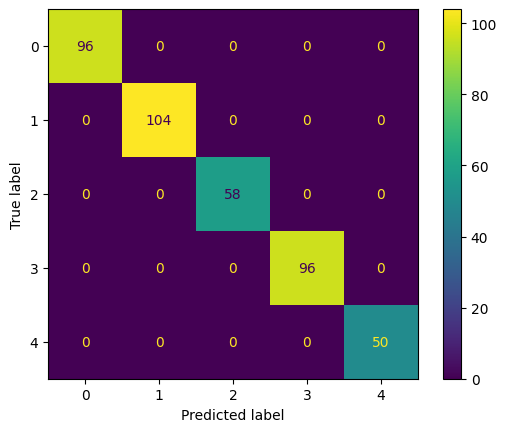

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

Random forest:
Accuracy score :1.0

Evaluation: The model was able to get 94 true positives for kicks, 104 true positives for 808s, 58 true positives for snares, 96 true positives for open hat and 50 true positives for closed hat. While this is a decent result, I did not look into the other measures such as recall or other scores since I received a similar result as the result of my models.


In [ ]:
# Saves model to be used by the prediction Jupyter
model.save('/content/drive/MyDrive/model')

# Loading data

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                384       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
Total params: 2629 (10.27 KB)
Trainable params: 2629 (

In [33]:
# Used a similar framework to creator aabalke33 on github who created drum-audio-classifier to create this loading data code. Link for more info can be found in the techincal appendix

abs_path = os.getcwd()
# Loads Deep Learning Model
model = tf.keras.models.load_model("/content/drive/MyDrive/model")

def sample_preparer(location, target_shape, sr=22050, top_db=50):
    sample = np.zeros(target_shape)
    y, sr = librosa.load(location, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=top_db)
    y = librosa.resample(y=y, orig_sr=sr, target_sr=sr)
    melspect = librosa.feature.melspectrogram(y=y, sr=sr)

    melspect = cv2.resize(melspect, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)


    sample[:melspect.shape[0], :melspect.shape[1]] = melspect

    return [sample]

In [34]:
model_input_shape = model.input_shape[1:]

def predict(audio_file_path):
    sample_data = sample_preparer(audio_file_path, target_shape=model_input_shape)
    prediction = model.predict(np.array(sample_data))
    return prediction

# Prompt the user to enter the audio file path
audio_file_path = input("Enter the path to the audio file: ")

KeyboardInterrupt: Interrupted by user

In [ ]:
# Audio file is fed into the model, and a prediction for classification is returned
prediction = predict(audio_file_path)

type_num = np.argmax(prediction, axis=1)

drum_types = ['808', 'Closed Hat', 'Kick', 'Open Hat', 'Snare']

print(f"Instrument Sample is: {drum_types[int(type_num[0])]}")

# Executive Summary:

### Goal & metrics.
The purpose of this project was to create an instrument classifier model that can accurately predict any given audio file and return the correct instrument. For the scope of this project I chose five unique instruments which are common in music production which include kick, snare, 808, open hat, and closed hat.  Coming from an audio and music background, I was curious in exploring the many factors that could distinguish an instrument. My metrics for this project was the accuracy score of which ever models I choose which in this case it was the MLP, Random forest and for the purposes of testing, the Convolutional Neural Network. For context, Convolutional Neural Networks is a deep learning model commonly used for image classification tasks.

### Findings.
From my findings, the models all had similar results so there wasnt neccesarily a best model for the purposes of the project so becuase of this, I decide to pick the model with the most potential for future growth which would be the CNN.

Something import to note however is that, for the purposes of which model was the most accurate to the data that I have, I ended up picking another neural network model, MLP, in addition to the other models that I made which included Random forest, CNN. This particular problem is a multiclass classification problem because it has many classes that require classification.

Through this experience I learned that while the CNN is possible to acheive correctly, the feasibility of this is a bit difficult due to computational power of the audio conversions which require more RAM and in general can be time extensive. I had this issue which led me to formatting my CNN model incorrectly and applying the one hot encoding to the CNN model which is not the appropriate way of classification. Learning from this, I did more research and applied a more appropriate model, MLP which mentioned previously is a neural network that has foundational architecture in deep learning and is used for various machine learning tasks, including classification.

As for my results with the MLP model, from my findings, the model is also overfit due to the accuracy score. While the loss is decreasing and the accuracy is increasing gradually and the model seems to able to accurately predict the validation set, this happens at a very fast rate which could be considered an issue. Something else I noticed is that the training and validation losses are similar numerically for example, 0.0025 and 0.0020 which could mean that it is working well and interpreting the data. There are many things that could be affecting this model however, I think that with more data and also different parameters this could potentially improve.

As for The CNN model, I had a test set loss of approx 0.0061 and a test set accuracy of 1.0 with default epoch value of 10 and .Some key finding from this is that the loss is decreasing and the accuracy is increasing gradually and the model is able to accurately predict the validation set however, the model overfits a bit due to the negative validation loss at 0.0066 at epoch 5.

For my Random Forest, I had very similar results as well with an accuracy of 1.0. The model was able to get 94 true positives for kicks, 104 true positives for 808s, 58 true positives for snares, 96 true positives for open hat and 50 true positives for closed hat. While this is a decent result, I did not look into the other measures such as recall or other scores since I received a similar result as the result of my models.

### Risks/limitations/assumptions

The biggest risk that I took was to try and run 2018 audio data files with the CNN without additional RAM. This caused my computer to crash several time and made me learn to scope my projects better. In addition to this I also used the numerical values of my instruments inaccuratly causing issues with the CNN since it was not intended to be used as such as it needs to take in image data. Initially,  I wanted to use pitch, time and amplitude as my features with the instrument being the target, however, due to recurring technical errors with the audio parameters, I was unable to execute and compare this CNN model v.s. that one. Based on my prediction, this could have improved the overfitting issues in the model as those features are strong as well as the variables given the analysis . In the future I plan to redo this with pitch, time, and amplitude to be the main features that I use and compare that with the CNN model.

# EDA

Based on my EDA, I think that using the CNN with feature engineering of pitch, time, amplitude would have probably be the best model. This is because with the spectrograms and 3D model, I was able to see that all the very unique and accurate representation of the instrument's unique characteristics. For example the 808 had larger amplitude and over time which shows that in the spectrogram. As for the open hat and closed hat, they show a correlation of similar pitch and amplitude over time and this is very accurate to the instrument because they are both very similar. Overall the pitch in the 3D model shows that there is a wide difference and outliers in the audio samples which can accurately represent how instrument samples can vary based on different aspects such as genre and processing choice. All models gave similar results based on the given data with the encoded values; however I believe that with more audio data and these features, the model would have seen improvement in overfitting.

### Variables of interest
The variables that I explored included assigning the instrument a numerical value through one hot encoding, pitch, time, amplitude, frequency and file paths. While I did not extract this unique information to my dataframe, I did explore it in the EDA and had the data saved in variables that were ready to use from the 3-D model and spectograms that I created. This will be helpful for future use and changes.

### Outliers/Data Cleaning
As for dealing with my outliers, I decided to not remove any because for the particular audio data that I had, I knew that there would be very stark difference in some of the sounds sonically due to the fact that outliers in this as they represent how samples can vary, for example, specific pitches for samples such as a snare can depend on the genre, key of the song, and the desired sound as there can be different kind of snares.I wanted to keep this in there for the purposes of potentially improving model performance . Another example of this is distinguishing sounds closely similar such as closed hat and open hat. While they do have some different pitches and frequencies they are also the instruments that are most similar in this group of instruments. Having the outliers there throughout my thought process would not necessarily contribute to the noise but help improve the model which is why I had decided to keep it. Looking back on that , I would try to see if I could remove it to see the difference. In this process there was little to no data imputation involved as during the cleaning process, I did not have to deal with average counts, means or extensive statistical analysis, however, I did have to make very risky decisions such as drop 50 unidentified hi hats which did not belong to closed nor open hat getting rid of a large amount of data.        


### Model selection
For my model selection, as mentioned prevsiouly, I ended up choosing the neural network model MLP as the correct model to use however in the future, I hope to use the CNN model and contnue the work. I also tried other models that I made which included Random forest, and the version I would have used for CNN if it worked. This particular problem is a multiclass classification problem because it has many classes that require classification.


### Implementation and Evaluation
These were my implementation, evaluation and inference as previously demonstrated,

MLP implementation:
- Using Sequential API in Keras
- Three hidden layers with 128, 64, and 32 units
- ReLU (Rectified Linear Unit) activation function to work for efficiency in managing audio data
- Softmax activation function to convert output into probabilities since this is a multi-class classification problem.
- Using optimizer Adam and categorical_crossentropy to compile and for a multiclass classification problem

CNN implementation:
- Three hidden layers with 128, 64, and 32 units
- ReLU (Rectified Linear Unit) activation function to work for efficiency in managing audio data
- Softmax activation function to convert output into probabilities since this is a multi-class classification problem.
- Using optimizer Adam and categorical_crossentropy to compile and for a multiclass classification problem

Random forest implementation:
Setting n_estimators=100 and Default parameters.


When evaluating these where my results and analysis at the time of when I ran my data as follows:
CNN:
Accuracy score:1.0
Loss:0.006

Evaluation : From my findings, the model has a test set loss of approx 0.0061 and a test set accuracy of 1.0 with default epoch value of 10 and .Some key finding from this is that the loss is decreasing and the accuracy is increasing gradually and the model is able to accurately predict the validation set however, the model overfits a bit due to the low validation loss at 0.0066 at epoch 5. The main issue with this model's implementation is the use of the one hot encoding column being processed on a model that does not take in numerical data and only takes in imaging data, this was an error on my end which is why I decided to use MLP.


MLP:
Accuracy score:1.0
Training Loss:5.3143e-04
Validation Loss: 4.7816e-04

Evaluation: From my findings, the loss is decreasing and the accuracy is increasing gradually and the model is able to accurately predict the validation set; however, this happens at a very fast rate. This model is working a bit better than the CNN because of The training and validation losses are similar numerically for example, 0.0025 and 0.0020. Overall however this is working similarly to the CNN model. There are many things that could be affecting this model however, I think that with more data and also different parameters this could potentially improve.

Random forest:
Accuracy score :1.0
Evaluation: The model was able to get 94 true positives for kicks, 104 true positives for 808s, 58 true positives for snares, 96 true positives for open hat and 50 true positives for closed hat. While this is a better result, I did not look into the other measures such as recall and received a similar result as the result of my models.

### My inference:
Based on my EDA, My inference is that using the CNN with feature engineering of pitch, time, amplitude would have probably been the best model. This is because with the spectrograms and 3D model  I was able to see that all images and Scatter points were very unique and accurate representation of the instrument's unique characteristics. For example the 808 had larger amplitude and over time which shows that in the spectrogram. As for the open hat and closed hat, they show a correlation of similar pitch and amplitude over time and this is very accurate to the instrument because they are both very similar. Overall the pitch in the 3D model shows that there is a wide difference and outliers in the audio samples which can accurately represent how instrument samples can vary based on different aspects such as genre and processing choice. All models gave similar results based on the given data with the encoded values; however I believe that with more audio data and these features, the model would have seen improvement in overfitting.


### Limitations
Some limitations include while I have worked with CNN before, I was not familiar with the process of how that could look like for audio until now. From my research, I found that as long as you have a way to preserve the temporal and spectral characteristics of audio data, such as the spectrograms or the 3D imaging, it is possible to use CNN in this particular way. You can also use audio data for a CNN across all 3 image channels(RGB) (Nandi, 2021). This will be helpful for future use.

### Technical Appendix and Sources

www.perplexity.ai , 2024, Sited in EDA

https://github.com/aabalke33/drum-audio-classifier/tree/main, 2023: Gave me a good starting point for framework and helped when creating the loading application that can input file path for model prediction.

https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab, 2023: Gave me more insight in CNN audio modeling. Sited in EDA

https://www.vocabulary.com/dictionary/pitch, 2024. Sited in EDA


Teachmeaudio.com, 2024, Sited in EDA
